# About
Coda (Cross Over Detection Analysis) is a tool which predicts and visualizes crossovers in F2 samples. It aims to guide the user though a step-by-step procedure from raw reads (fastq files) to results in the form of plots and tables.

The core hypothesis of this project is that given assemblies of two plants A and B, reads from plant A would map to assembly A over B. As such, Coda relies on alignment to what we termed a "dual genome" - a concatnated reference of the two parents.  

Development of Coda was done in [Weizmann Institute, Avraham Levy's Lab](https://www.weizmann.ac.il/plants/levy/) by Jules Zisser.

## Pipeline prerequisites  
- [BWA](http://bio-bwa.sourceforge.net/bwa.shtml#3)
- [samtools](http://www.htslib.org/doc/samtools.1.html)
- [Picard](https://software.broadinstitute.org/gatk/documentation/tooldocs/4.0.4.0)
- [bedtools](https://bedtools.readthedocs.io/en/latest)
- [Python 3.7+](https://www.python.org) with:
    - pandas
    - matplotlib
    - [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/)

# Coda workflow

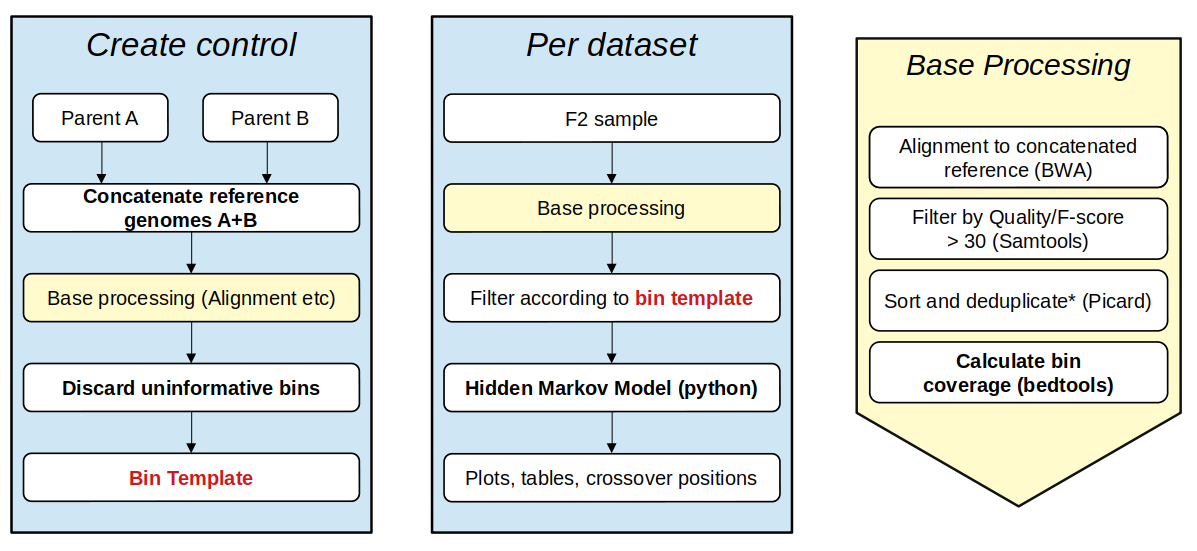

## Assembling the reference
1. **Change fasta file headers.** Determines the chromosome notation used downstream. Use distinct, alphabetical names. *Do not* use digits.
```bash
 awk '/^>/{print ">alpha" ++i; next}{print}' < genomeA.fasta
 awk '/^>/{print ">beta" ++i; next}{print}' < genomeB.fasta
 ```
2. **Concatenate reference files.** This is the reference all samples are mapped to.
```bash
cat genomeA.fasta genomeB.fasta > genomeAB.fasta
```
3. **Generate genome sizes.** Used to generate bins. View `genomeAB_sizes.txt` afterwards to verify the genome names and sizes.
```bash
# module load samtools-gnu 
samtools faidx genomeAB.fasta
cut -f1,2 genomeAB.fasta.fai > genomeAB_sizes.txt # notice input is .fai here
```
4. **Index concatenated reference.** Required for BWA alignment.
```bash
# module load bwa-gnu
bwa index genomeAB.fasta
```

## Create bin template
5. **Map source alignments and filter.** Using `BWA mem`, map each pair of reads `genomeA_R1_00N.fastq.gz`, `genomeB_R2_00N.fastq.gz` to `genomeAB.fasta` (`-t 5` is the amount of parallel threads, it does not alter the alignment result). Pipe the output to samtools in order to filter out reads with quality / Fred score < 30 and convert to BAM format (binary / smaller form of SAM).
```bash
# module load bwa-gnu samtools-gnu
for R1 in genomeA_control_L001_00*R1.fastq.gz; 
do
    bwa mem -t 5 references/genomeAB.fasta $R1 $R2 | samtools view -Sbh -q 30 - > genomeA_control_00N.bam
done
```
4. **Merge and sort** all alignment files of the same library.
```bash
samtools merge genomeA_control_001.bam genomeA_control_002.bam  [...] > genomeA_control_merged.bam
samtools sort genomeA_control_merged.bam > genomeA_control_merged.sorted.bam
```
6. **Deduplicate** in order to retain unique reads
```bash
# module load jdk picard
picard MarkDuplicates I=genomeA_control_merged.sorted.bam O=genomeA_control_merged.sorted.dedup.bam M=genomeA_control_merged.dedup_metrics.txt REMOVE_DUPLICATES=true
```
7. **Create bins table** (decide on bin size, step size) using `make_bins.py`.
```bash
python make_bins.py genomeAB_sizes.txt 200
```
8. **Calcuate control coverage** to see where each parent aligns
```bash
bedtools coverage -counts -sorted -a genomeAB_sizes.bins.txt -b genomeA_control_merged.sorted.dedup.bam > genomeA_control.cov-sizes.bedgraph
```
8. **Filter uninformative bins** with `filter_genomes.py`. This results in reads that aren't unique to either parent to be thrown out, resulting in a much cleaner template.
```bash
python filter_genomes.py genomeA_control.cov-sizes.bedgraph genomeB_control.cov-sizes.bedgraph genomeAB_template.cov-sizes.bedgraph
```
9. **Optional: Calculate average bin coverage**.
```bash
cat genomeA_control.cov-sizes.bedgraph | awk '{sum+=$4} END { print "Average = ",sum/NR}'
```


## Prepare individual dataset
Sample level steps can be mass deployed using the script `processing_pipeline.sh` coupled with `dirs_process.sh`.  
The pipeline expects as an input the R1 fastq file of a reads pair.  
All of the commands are the same as processing the control samples, except for the last step: when calculating coverage, use the template `genomeAB_template.cov-sizes.bedgraph` generated from `filter_genome.py` in step 2.2.9 instead of `genomeAB_sizes.bins.txt`.

1. Map sample reads to concatenated reference `genomeAB.fasta`
2. Quality filter and sort
3. Remove duplicates
4. Get coverage over bin template using bedtools

## Analysis with Coda
There are multiple python dependencies required in order for `coda.py` to run. The recommended way to set up a suitable environment is by using [Anaconda3](https://www.anaconda.com/distribution/).
```bash
module load anaconda # for servers that use "module" imports such as wexac
conda env create -f coda_env.yml # creates a virtual environment with specified requirements
conda activate xoe # activate it
python coda.py my_sample.dedup.cov.bedgraph predict # running the default pipeline on file "my_sample"
```
For advanced users who would rather use their own environments, the dependencies are listed below. Later versions of the packages are likely to work, but were not tested.
```
  - python=3.7.*                                   
  - pandas=0.24.*
  - matplotlib=3.1.2
  - hmmlearn=0.2.3
```

# Module documentation

## transform_data() - aggregating read count
Two methods: `arbitrary` or `robust`, which use `group_count` or `bin_size` respectively.
`Arbitrary` is used by default.  
Plotted below is an example of the sample data processed by the different methods.

**Arbitrary - aggregate every `group_count` points.**
* Consistent distribution across samples
* Less bins
* Clear Heterozygote 0 group
* Better results overall

**Robust - all points in each `bin_size` section are grouped**
* Distribution highly affected by coverage
* More bins
* Bins contain very few datapoints
* Better defined aggregation

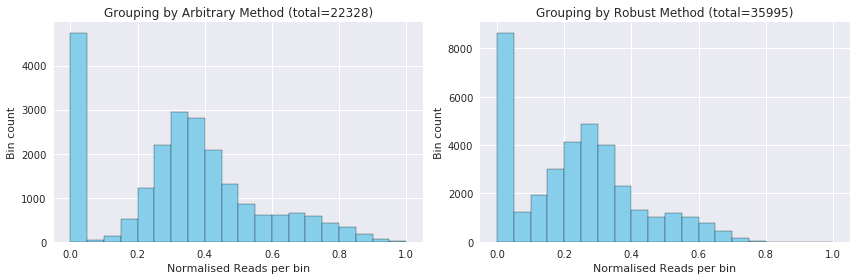

In [5]:
fig = plt.figure(figsize=(12,4))

for i, method in enumerate(['arbitrary', 'robust']):
    s = coda.CrossoverDetector(log_level=2)
    s.transform_data(kiril_files(10), method=method)
    ax = plt.subplot(1,2,i+1)
    ax.hist(s._data.val, bins=np.arange(0, 1.01, 0.05), color='skyblue')
    ax.set_ylabel('Bin count')
    ax.set_xlabel('Normalised Reads per bin')
    ax.set_title(f'Grouping by {method.capitalize()} Method (total={len(s._data)})')
plt.tight_layout()

## read_context() - input centromere data
Centromeres tend to have a lot of variations. Adding centromere positions means these inconsistent regions will be taken out before training, as well as marked in the results.  
As of 2019, the context positions in `fname` needs to be listed as follows:

In [6]:
!cat centromere_pos.bed

chr1	14000000	15599999
chr2	2900000	3949999
chr3	13600000	14549999
chr4	2000000	4259999
chr5	10930000	12659999


## Hidden markov model training
By default the model will be initialized with 3 states - Homozygote A, Heterozygote, and Homozygote B. Each state is defined by mean, variance, and transition odds. During the fitting process these parameters are adjusted in a process called [Expectation-maximization](https://www.statisticshowto.datasciencecentral.com/em-algorithm-expectation-maximization/), or EM for short. It's recommended to train the model on multiple samples in order to produce more reliable results.

In [7]:
print('Approximate position offset:')
pd.Series({'min': 166.5, 'p25': 2364.25, 'p50': 6860.5, 'p75': 13613.5, 'max': 331572.5})

Approximate position offset:


min       166.50
p25      2364.25
p50      6860.50
p75     13613.50
max    331572.50
dtype: float64

## [Experimental] Syri - genome matching

Note: Syri was considered as a possibility to match crossover locations during development, but was eventually discarded.

```bash
module load mummer
nucmer --maxmatch -c 100 -b 500 -l 50 refgenome qrygenome
delta-filter -m -i 90 -l 100 out.delta > out_m_i90_l100.delta
show-coords -THrd out_m_i90_l100.delta > out_m_i90_l100.coords
~/apps/syri/syri/bin/syri -c out_m_i90_l100.coords -r TAIR10_filtered.fasta -q ../Denovo_Ler_Assembly/GCA_001651475.1_Ler_Assembly_genomic_filtered.fasta -d out_m_i90_l100.delta --nc 5
```
Sources:  
[Syri Publication Additional File 2 Col-0-Ler](https://www.biorxiv.org/content/10.1101/546622v3.supplementary-material)  
https://www.biostars.org/p/49820/  
[Assembly match 3 Syri](https://schneebergerlab.github.io/syri/example.html)  

# Python usage example

In [2]:
import coda

# Notebook only settings
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
sample_files = {'default_revised': "collab/sample-E-MTAB-4657/ERR1432437.sorted.dedup.template-200-col-ler-7-11-19.bedgraph",
                'kiril_revised': '/home/labs/alevy/Collaboration/novaseq6_09_2019/demultiplexed_fastq/O/KirilsF2_2/KirilsF2_2_S2_.dedup.cov.bedgraph',
                'f1': "/home/labs/alevy/Collaboration/crossover_detection/F1_col_ler_merge/F1_artificial.q30.sorted.dedup.cov-200-200.bedgraph",
                'shay_lowcov': '~/datasets/shay/E-MTAB-6577/ERR2377152.q30.sorted.dedup.cov-200-200.bedgraph'}
def kiril_files(num):
    s = '/home/labs/alevy/Collaboration/novaseq6_09_2019/demultiplexed_fastq/O/KirilsF2_{}/KirilsF2_{}_S{}_.dedup.cov.bedgraph'
    return s.format(num, num, num)

In [5]:
kiril_files(7)

'/home/labs/alevy/Collaboration/novaseq6_09_2019/demultiplexed_fastq/O/KirilsF2_7/KirilsF2_7_S7_.dedup.cov.bedgraph'

Coda can be used as either a script or a module, which share the same functions. In this example it will be used as a python module.  
The same result can be achieved by running the script like so:
```bash
python coda.py --group-count 10 --context centromere_pos.bed --hmm res_hmm.pickle KirilsF2_7_S7_.dedup.cov.bedgraph predict --smooth-model v1 --smooth-window 10
```

We begin by importing coda to our project, as well as other packages used for data manipulation and visualisation.


In [6]:
sample1 = coda.CrossoverDetector()
sample1.coda_preprocess(kiril_files(7), context_fname='centromere_pos.bed', group_count=10)
                        #'res_hmm.pickle'
sample1.coda_detect(smooth_model='v1', smooth_window=10)

[2020-01-30 17:53:13.998,  INFO] Loading and aggregating data from file "/home/labs/alevy/Collaboration/novaseq6_09_2019/demultiplexed_fastq/O/KirilsF2_7/KirilsF2_7_S7_.dedup.cov.bedgraph" according to method "arbitrary".
[2020-01-30 17:53:15.146,  INFO] Successfully loaded 'KirilsF2_7_S7_.dedup.cov.bedgraph'. Mean coverage is 10.732.
[2020-01-30 17:53:15.146,  INFO] Reading centromere boundries from file "centromere_pos.bed".
[2020-01-30 17:53:15.153,  INFO] Started genome_hmm_detection() on "KirilsF2_7_S7_.dedup.cov.bedgraph"
[2020-01-30 17:53:15.153,  INFO] Fitting HMM based on this sample.
[2020-01-30 17:53:15.320,  WARN] Initializing new model.
[2020-01-30 17:53:18.552,  INFO] Predicting most likely state according to HMM.
[2020-01-30 17:53:19.101,  INFO] Extractring initial transition locations.
[2020-01-30 17:53:19.124,  INFO] Found 289 suspects.
[2020-01-30 17:53:19.124,  INFO] Smoothing by filling gaps <10.
[2020-01-30 17:53:19.267,  INFO] Re-exctracting crossover positions.
[

Text(0.5, 1.0, 'Pre Transformation Coverage Per Bin Distribution')

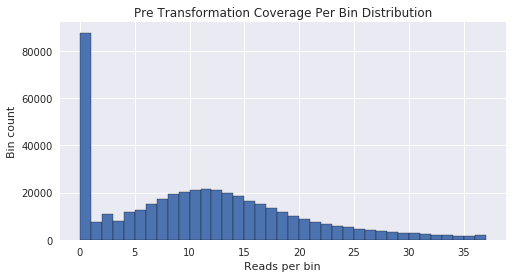

In [7]:
plt.figure(figsize=(8,4))
sample1._raw_data.val.hist(bins=np.arange(sample1._raw_data.val.max()), label='Read count')
plt.ylabel('Bin count')
plt.xlabel('Reads per bin')
plt.title('Pre Transformation Coverage Per Bin Distribution')

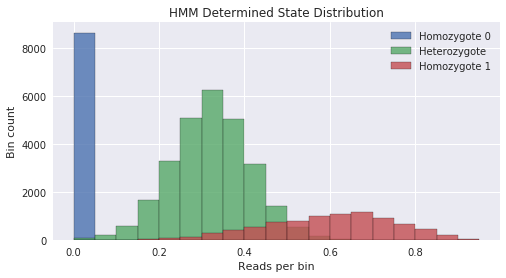

In [8]:
plt.figure(figsize=(8,4))
plt.ylabel('Bin count')
plt.xlabel('Reads per bin')
plt.title('HMM Determined State Distribution')

for pred, name in enumerate(['Homozygote 0', 'Heterozygote', 'Homozygote 1']):
    sample1._data_predictions[sample1._data_predictions.pred == pred].val.hist(bins=np.arange(0,1,0.05),
                                                                                   alpha=0.8, label=name)
plt.legend()

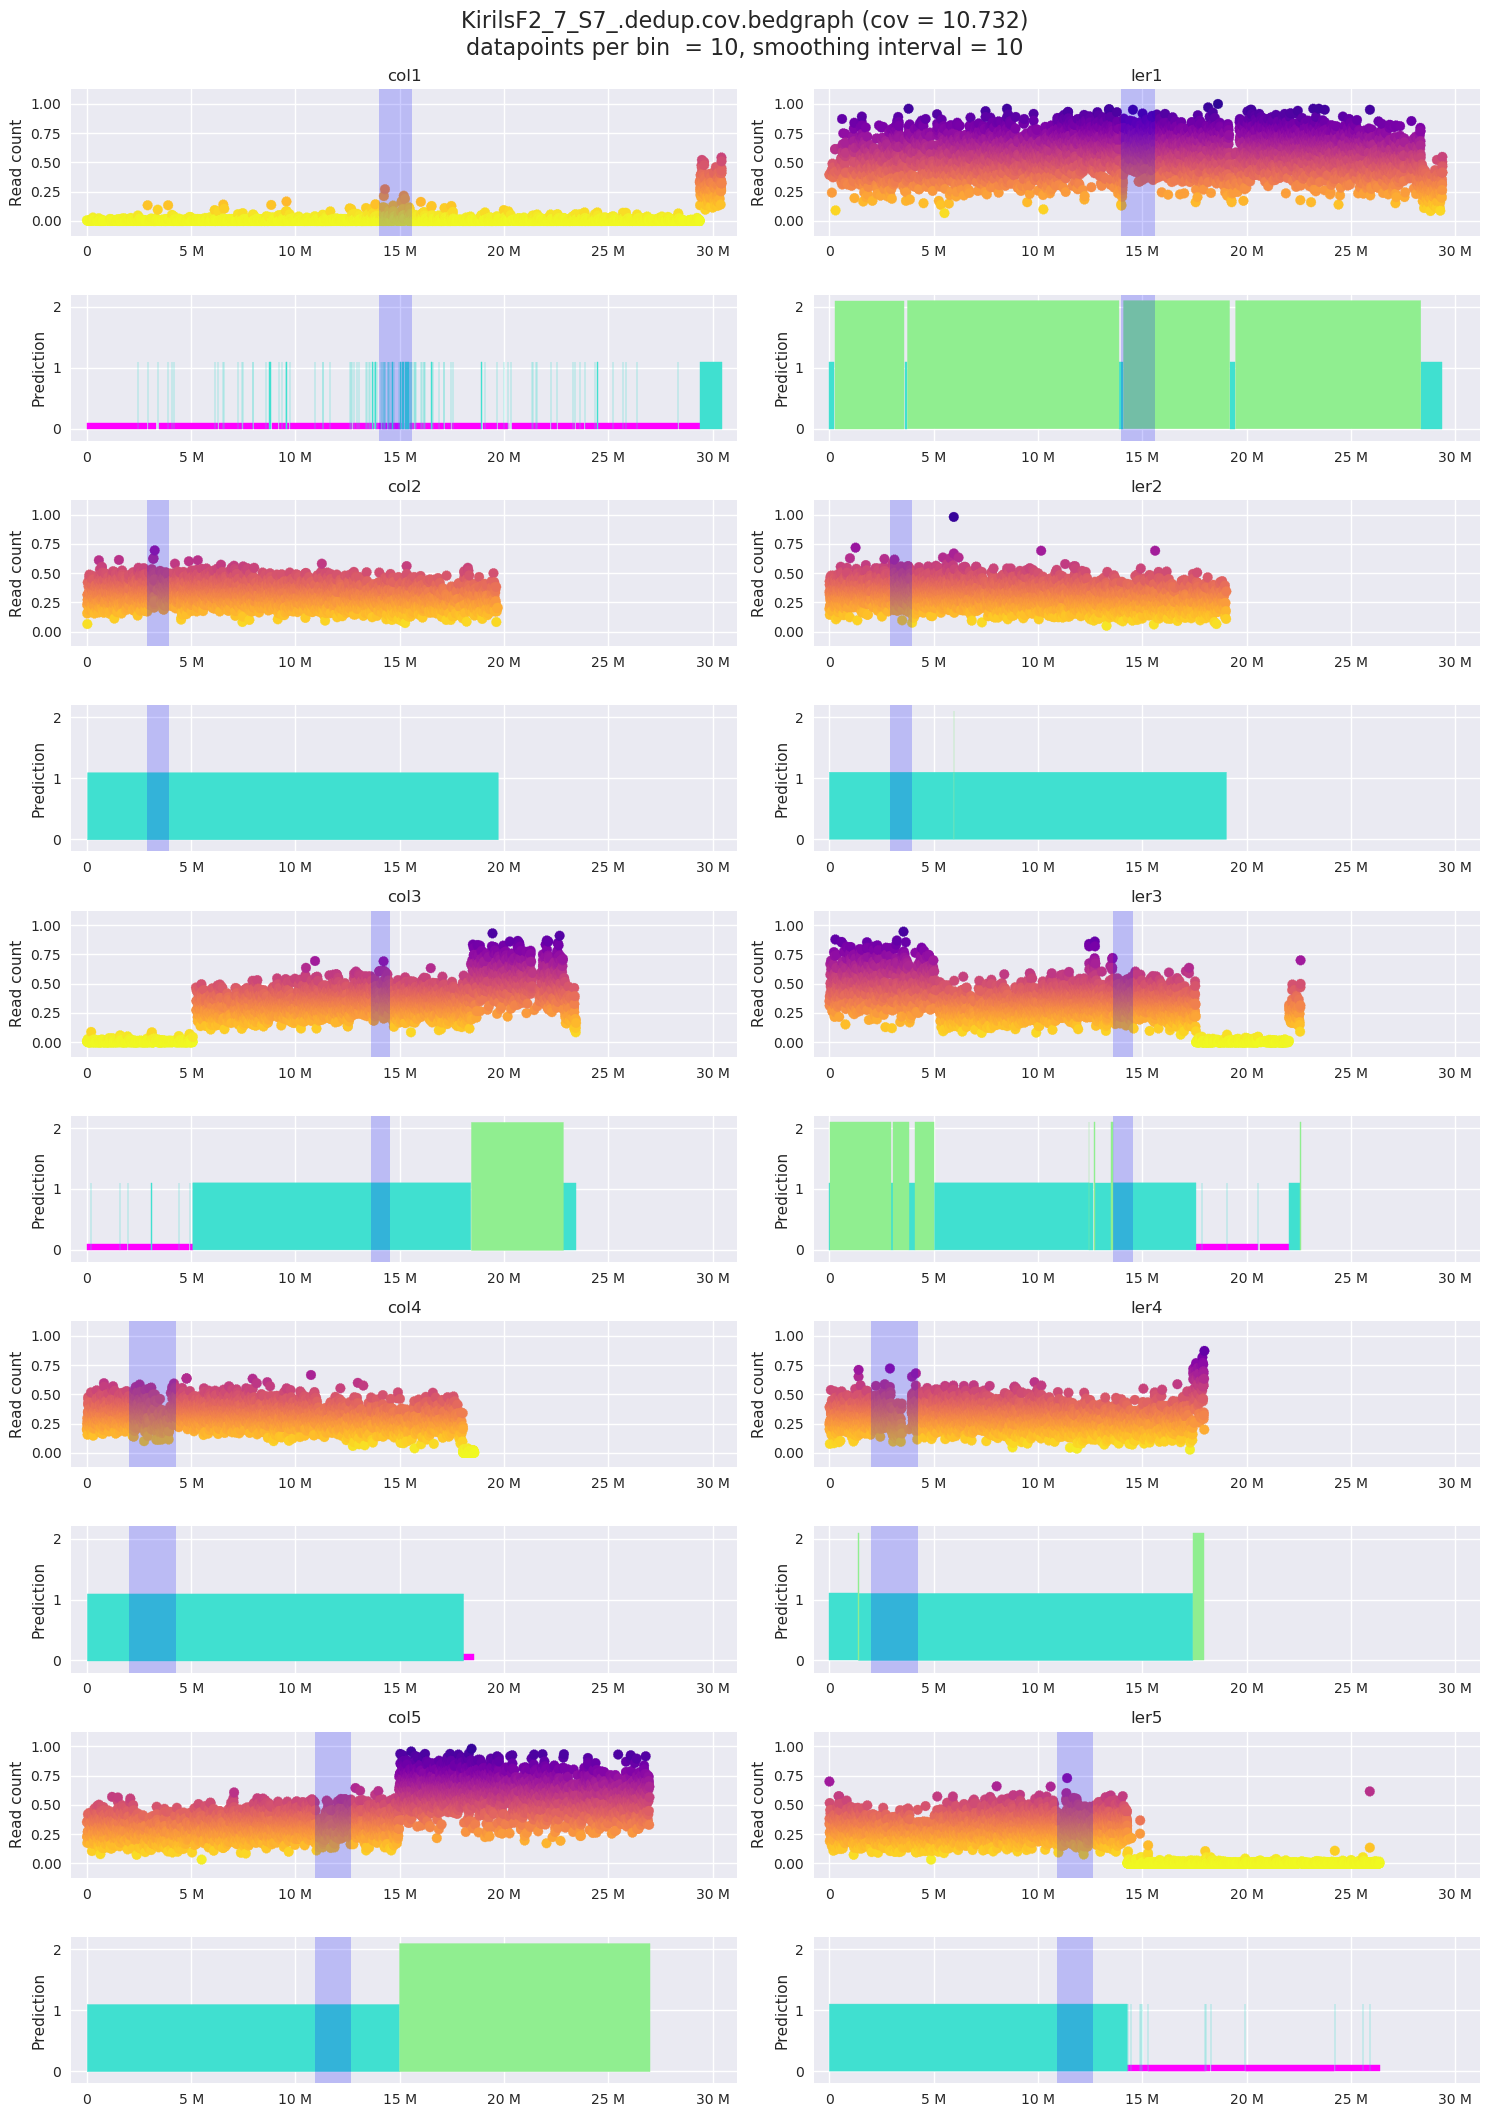

In [9]:
sample1.plot_hmm(val_column='pred')

In [11]:
from tabulate import tabulate

print(tabulate(sample1.crossovers, tablefmt="pipe", headers="keys"))

|       | chrm   |    start |      end |    val |   pred | probs               |   smooth |   updated |   change |   abs_pos |   pos_ler |   dist | possible_dup   |   binsize |   binsize_percentile | context    |
|------:|:-------|---------:|---------:|-------:|-------:|:--------------------|---------:|----------:|---------:|----------:|----------:|-------:|:---------------|----------:|---------------------:|:-----------|
|  2298 | col1   | 15079201 | 15086201 | 0.0175 |      0 | [0.983 0.017 0.   ] |       -1 |         0 |        1 |    0.4958 |  13884201 | 0.0234 | False          |      7000 |                82.91 | centromere |
|  2326 | col1   | 15488401 | 15491401 | 0.035  |      1 | [0.001 0.999 0.   ] |       -1 |         1 |        0 |    0.5091 |  14099001 | 0.0294 | False          |      3000 |                47.87 | centromere |
|  5071 | col1   | 29377401 | 29381001 | 0      |      0 | [1. 0. 0.]          |       -1 |         0 |        1 |    0.9656 |  28350001 | 0.0009 | 